<h1><center>IST 597 Foundations of Deep Learning</center></h1>

---

<h2><center>Dropout and Regularization</center><h2>
<h3><center>Neisarg Dave</center><h3>

In [ ]:
import torch
import random
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
%matplotlib inline

device = torch.device("cuda:0")

seed = 1234 
random.seed(seed)
torch.manual_seed(seed)

In [ ]:
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

valid_dataset, train_dataset = torch.utils.data.random_split(train_dataset, [10000, 50000])

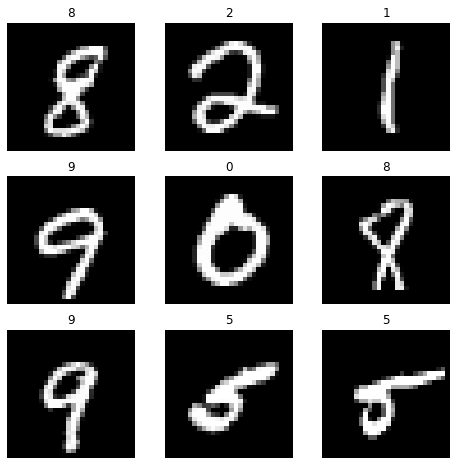

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Dropout

Droput means dropping or masking some values of the feature tensor before passing it on to the next layer. The selected values are mapped to $0$. Each neuron is selected with probability $p$ to be masked out with $0$. The final tensor is then scaled by $\frac{1}{1-p}$ to maintain the activations.

$$x = \frac{1}{1-p} Dropout(x, p)$$ 

Dropout is only implemented during training phase. No gradients pass through the turned off neurons in that training iteration.

Neuron probability for dropout can be calculated using Bernaulli Distribution $\sim Bern(p)$

<br>
<br>

Other ways of implementing dropouts: 

1) Use Gausian Distribution for dropout gate. In this case you will not need to rescale the output. Why?

2) Instead of applying Dropout on the feature maps, apply dropout on the weight tensors. How will this affect training ?



In [ ]:
data = torch.ones([10, 10]).type(torch.float)
dout = torch.nn.functional.dropout(data, p = 0.4)
print(data)
print(dout)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.0000, 0.0000, 0.0000, 1.6667, 1.6667, 1.6667, 0.0000, 0.0000, 1.6667,
         0.0000],
        [1.6667, 0.0000, 1.6667, 1.6667, 1.6667, 1.6667, 1.6667, 1.6667, 1.6667,
         1.6667],
        [1.6667, 0.0000, 1.6667, 0.0000, 0.0000, 0.0000, 0.0000, 1.6667, 1.6667,
         0.0000],
        [0.0000, 0.0000, 1.6667, 1.6667, 0.0000, 0.0000, 1.6667, 1.6667, 0.0000,
         0.0000],
        [1.6667, 1.6667, 0.0000, 1.6667, 1.6667, 1.6667, 1.6667, 0.0000, 1.6667,
         1.6667],
    

In [ ]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self, dropout = 0):
    super(NeuralNetwork, self).__init__()
    self.output = torch.nn.Linear(784, 10)
    if dropout > 0:
      self.dropout = torch.nn.Dropout(p=dropout) 
    else:
      self.register_parameter('dropout', None)
  
  def forward(self, x):
    if self.dropout is not None:
      x = self.dropout(x)
    out = self.output(x)
    return out

## Regularization
$$L_1 = \lambda \sum_{i} |w_i|$$
$$L_2 = \frac{\lambda}{2} \sum_{i} ||w_i||^2$$

In Pytorch L2 regularizer is already implemented as *weight decay* in optimizer.

Note: Do not confuse regularizers for norms. E.g. For L_2 is the sum of square of all weight terms. To calcuate 2-norm, take square root of the sum of squared parameters.

$$2-norm =\sqrt{ \sum_{i} ||w_i||^2 }$$

In pytorch torch.linalg.norm calculates p-norms

## Derivative of Regularization Terms

$$\frac{\partial{L_1}}{\partial w_i} = \lambda sgn(w_i) $$
$$\frac{\partial{L_2}}{\partial w_i} = \lambda w_i $$

Here sgn(x) is a sign function.



In [ ]:
## Defining our own L1 regularizer
class L1(torch.nn.Module):
  def __init__(self, coeff):
    super(L1, self).__init__()
    self.coeff = coeff

  def forward(self, parameters):
    w = 0
    for param in parameters:
      w += torch.sum(torch.abs(param))
    return self.coeff*w


In [ ]:
model = NeuralNetwork(dropout = 0).cuda()

In [ ]:
import matplotlib.gridspec as gridspec
def live_plots(weight, grad, x, y, xlim, ylim):
    clear_output(wait=True)
    fig = plt.figure(figsize=(32, 16))
    gs0 = gridspec.GridSpec(2, 2, figure=fig)
    gs02 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0[1])
    
    #plt.figure(figsize=figsize) 
    ax1 = fig.add_subplot(gs0[0])
    # ax3 = fig.add_subplot(gs00[-1, -1])
    ax1.set_xlim(0, xlim)
    ax1.set_ylim(0, ylim)
    x = [float(i) for i in x]
    y = [float(i) for i in y]
    
    if len(x) > 1:
        ax1.scatter(x,y, label='axis y', color='k') 
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, [x * m for x in x] + b)

    ax1.set_title("Loss Curve")
    ax1.grid(True)
    ax1.set_xlabel('# Iterations')
    ax1.set_ylabel('Loss')
    #plt.show();

    #figure = plt.figure(figsize=(16, 8))
    cols, rows = 5, 2
    for ii in range(weight.shape[0]):
      img = weight[ii].reshape(28, 28)
      ax = fig.add_subplot(gs02[ii//5, ii%5])
      #figure.add_subplot(rows, cols, ii+1)
      ax.set_title(ii)
      ax.axis("off")
      ax.imshow(img.squeeze(), cmap="gray")

    ax2 = fig.add_subplot(gs0[2])
    ax2.hist(weight, 50, density=True, facecolor='g', alpha=0.75)
    ax2.set_title("Distribution of Weight Matrix")

    ax3 = fig.add_subplot(gs0[3])
    ax3.hist(grad, 50, density=True, facecolor='b', alpha=0.75)
    ax3.set_title("Distribution of Gradients of Weight Matrix")

    plt.show()

In [ ]:
from torch.utils.data.dataloader import DataLoader
train_data = DataLoader(train_dataset, batch_size = 4096)
valid_data = DataLoader(valid_dataset, batch_size = 4096)
print(len(train_data), len(valid_data))

13 3


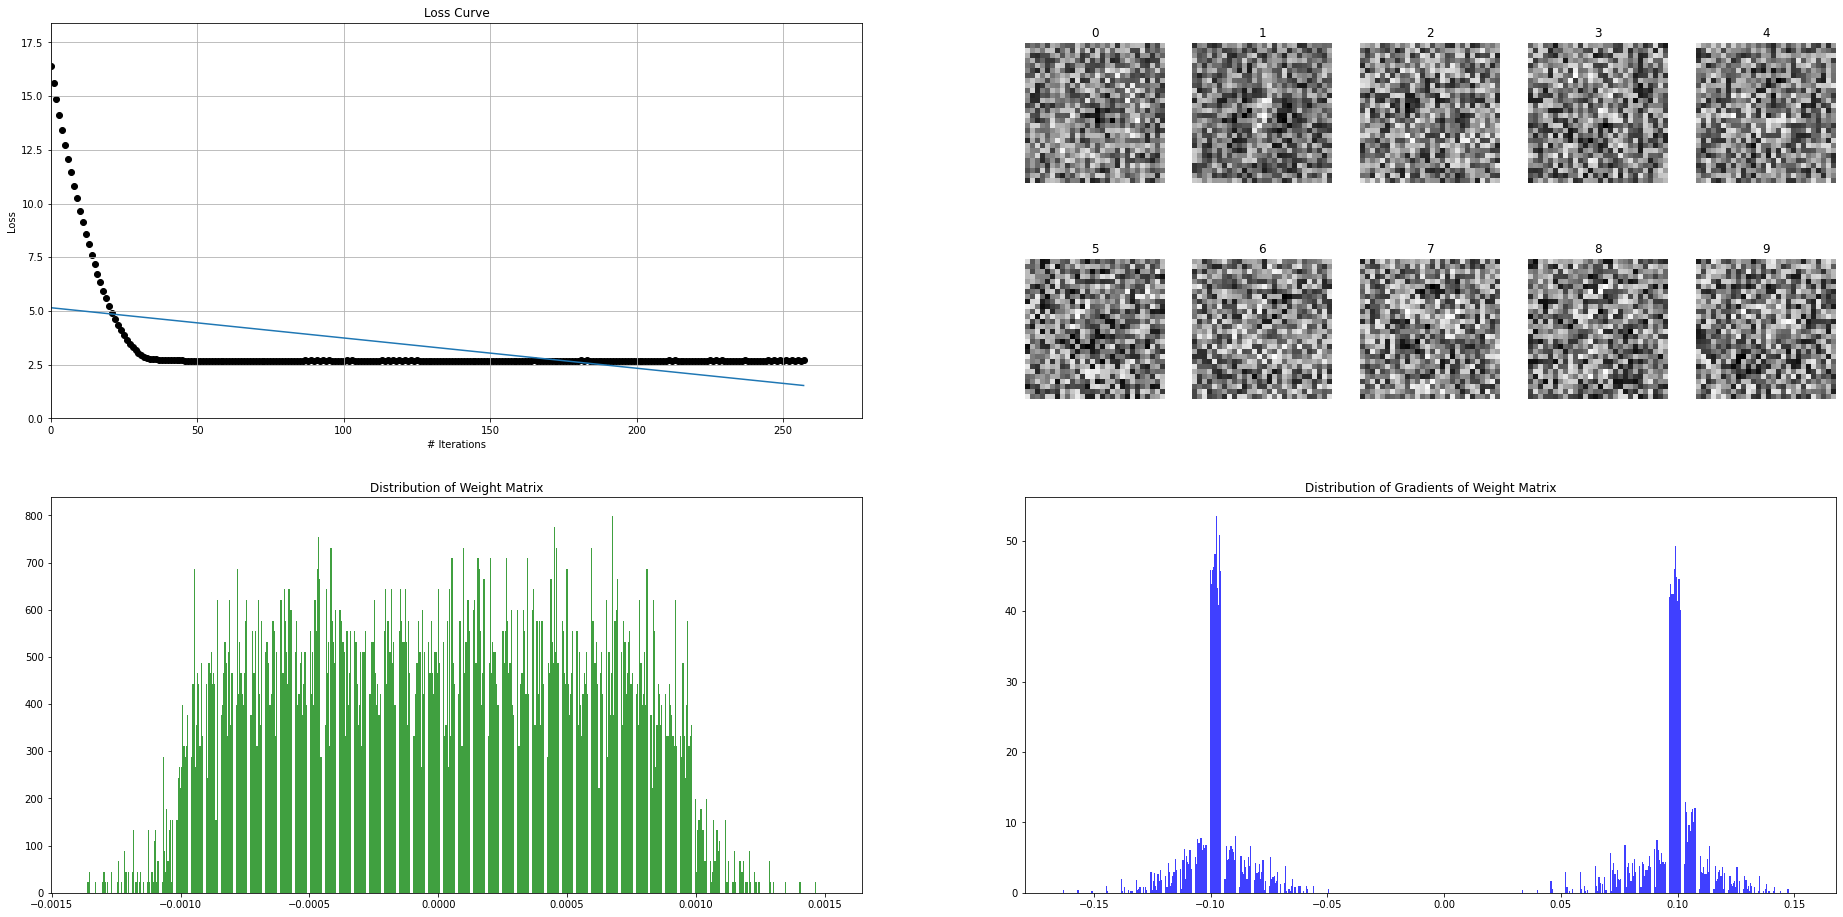

In [ ]:
# with L2 regularization: 
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 10)

# with L1 regularization:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0)
L1_reg = L1(0.1)


loss_fn = torch.nn.CrossEntropyLoss()

nepochs = 20
loss_buffer = []
steps_buffer = []
for epoch in range(nepochs):
  for ii, batch_data in enumerate(train_data):
    # prepare data
    data, labels = batch_data
    data = data.reshape([-1, 784]).cuda()
    labels = labels.cuda()
    
    # run model
    logits = model(data)
    
    # calculate loss 
    #loss = loss_fn(logits, labels)
    loss = loss_fn(logits, labels) + L1_reg(model.parameters())

    # run optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # plot loss and visualize weights
    loss_buffer.append(loss.detach().cpu())
    steps_buffer.append(epoch*len(train_data) + ii)
    if ii % 10 == 0:
      live_plots(model.output.weight.detach().cpu(), model.output.weight.grad.detach().cpu(),
                 steps_buffer, loss_buffer, 
                steps_buffer[-1]+20, max(loss_buffer) + 2 )
      
  

TODO: <br>
1) What happens when you combine L1 and L2 regularizers? <br>
2) Can you think of any other forms of regularizers? <br>
3) What more can you do with your features / weights / gradients ? <br>
